In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units
import earthpy.spatial as es
import rasterio

# import personal modules
sys.path.append('../modules') # Path to modules
from preprocess_dataframes import combine_ivt_ar_prec_df
import nclcmaps as nclc
from plotter import draw_basemap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
# Set up paths

path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
path_to_work = '/cw3e/mead/projects/cwp140/scratch/dnash/data/preprocessed/SEAK-WRF-PCPT/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [14]:
xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
community_lst = lbl1
lbl_align = ['center', 'left', 'right', 'center', 'right', 'left'] # where the labels go
ext1 = [-141., -130., 54., 61.] # extent of SEAK

# list of extents for each community
dx = 1.5 # this works for our paper
dy = 1.5 # this works for our paper

dx = 0.5 # for supplemental/community partners
dy = 0.5 # for supplemental/community partners

ext_lst = []
for x,y in zip(xs,ys):
    ext_lst.append([x-dx, x+dx, y-dy, y+dy])

ext_lst

[[-135.9519, -134.9519, 57.6122, 58.6122],
 [-135.8277, -134.8277, 58.9538, 59.9538],
 [-136.3894, -135.3894, 58.8988, 59.8988],
 [-140.171, -139.171, 59.0121, 60.0121],
 [-133.6358, -132.6358, 54.9769, 55.9769],
 [-132.9009, -131.9009, 55.04, 56.04]]

In [12]:
temporal_res = 'daily'
fname = path_to_data + 'preprocessed/SEAK-WRF_PCPT_{0}_composite.nc'.format(temporal_res)
prec_comp  = xr.open_dataset(fname)
## calculate average of all 6 communities
prec_mean = prec_comp.mean('community')

## subtract the mean from the original composites
prec_diff = prec_comp - prec_mean

### Load elevation data

In [5]:
## Open GMTED2010 7.5 arc second elevation data
elev = xr.open_dataset(path_to_data + 'preprocessed/seak_gmted_mea075.nc')

## Plot Precitation Composites

In [6]:
# Set up projection
mapcrs = ccrs.Mercator()
# mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = elev.lat
lons = elev.lon
dx = np.arange(lons.min().round(),lons.max().round()+0.25,+0.25)
dy = np.arange(lats.min().round(),lats.max().round()+0.25,+0.25)

ext1 = [-141., -130., 54., 61.] # extent of SEAK

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

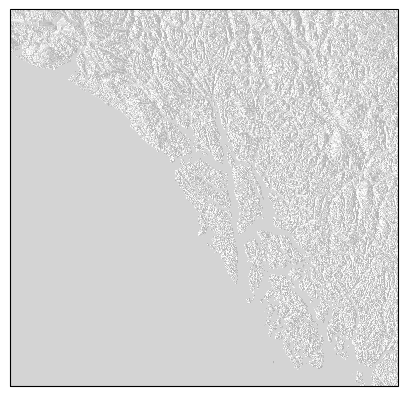

In [10]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(1, 1, 1, projection=mapcrs)
fig.set_size_inches(5, 5)
# cf = ax.imshow(hillshade, cmap=cmo.gray, alpha=0.3)
cf = ax.pcolormesh(elev.lon, elev.lat, elev.hillshade, rasterized=True, cmap=cmo.gray, shading='auto', transform=datacrs, alpha=0.3)



In [ ]:
left_lat_lst = [True, False, False, True, False, False]
bottom_lon_lst = [False, False, False, True, True, True]
# Create figure
fig = plt.figure(figsize=(8, 12))
fig.dpi = 300
fname = path_to_figs + 'extreme-AR_prec_composite_all_{0}'.format(temporal_res)
fmt = 'png'

nrows = 2
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.3,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.35, cbar_size='3%',label_mode='')

# for k, ax in enumerate(axgr):
for k in np.arange(nrows*ncols):
    
    # Set tick/grid locations
    diff = 0.1
    ext = ext_lst[k]
    dx = np.arange(ext[0],ext[1]+diff,diff)
    dy = np.arange(ext[2],ext[3]+diff,diff)
    
    ax = plt.subplot(nrows, ncols, k+1, projection=mapcrs)
    ds = prec_comp.sel(community=community_lst[k])
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=True)
    
    # topo with grey-scale cmap
    cs = ax.pcolormesh(elev.lon, elev.lat, elev.hillshade, rasterized=False, cmap=cmo.gray, shading='auto', transform=datacrs, alpha=0.8)

    # Contour Filled
    prec = ds.PCPT.values
    print(np.nanmax(prec))
    if temporal_res == 'hourly':
        clevs = np.arange(0.1, 2.2, 0.1)
        clabel = 'precipitation (mm hour$^{-1}$)'
    elif temporal_res == 'daily':
        clevs = np.arange(0.0, 105, 5)
        clabel = 'precipitation (mm day$^{-1}$)'
    cf = ax.contourf(ds.lon.values, ds.lat.values, prec, transform=datacrs,
                     levels=clevs, cmap=nclc.cmap('WhiteBlueGreenYellowRed'), alpha=0.5, extend='max')
    
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
    # # elevation contour
    # clevs=np.array([500, 1000, 2000])
    # cs = ax.contour(wrflons, wrflats, elev, clevs, colors='k', linewidths=0.75,
    #                 linestyles='solid', transform=datacrs)

    titlestring = '({0}) {1}'.format(letter_lst[k], community_lst[k])
    ax.text(0.025, 0.98, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(ax)

    # Plot Location of community pts
    ax.plot(xs[k], ys[k], 'ko', markersize=6, transform=datacrs)

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
cb.set_label(clabel, fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

/tmp/ipykernel_9713/3145625372.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(nrows, ncols, k+1, projection=mapcrs)
